# Applied Deep Learning - a use case based approach to understand deep neural networks

### Umberto Michelucci

Buy the book: https://www.apress.com/us/book/9781484237892

(C) Umberto Michelucci 2018-2019 - umberto.michelucci@gmail.com 

github repository: https://github.com/Apress/applied-deep-learning

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
import sklearn.linear_model as sk

# Load the Boston dataset

First we load the Boston dataset to be able to go into a situation of extreme overfitting.

# Load the data

## This is the easiest way - get the Boston dataset online

In [52]:
boston = load_boston()
features = np.array(boston.data)
target = np.array(boston.target)

In [53]:
n_training_samples = features.shape[0]
n_dim = features.shape[1]

print('The dataset has',n_training_samples,'training samples.')
print('The dataset has',n_dim,'features.')

The dataset has 506 training samples.
The dataset has 13 features.


In [54]:
def normalize(dataset):
    mu = np.mean(dataset, axis = 0)
    sigma = np.std(dataset, axis = 0)
    return (dataset-mu)/sigma

In [55]:
features_norm = normalize(features)

In [56]:
np.random.seed(42)
rnd = np.random.rand(len(features_norm)) < 0.8

train_x = np.transpose(features_norm[rnd])
train_y = np.transpose(target[rnd])
dev_x = np.transpose(features_norm[~rnd])
dev_y = np.transpose(target[~rnd])

print(train_x.shape)
print(train_y.shape)
print(dev_y.shape)

(13, 399)
(399,)
(107,)


In [57]:
train_y = train_y.reshape(1,len(train_y))
dev_y = dev_y.reshape(1,len(dev_y))

print(train_y.shape)
print(dev_y.shape)

(1, 399)
(1, 107)


## Save the data as files

In [65]:
np.savetxt("boston_train_x.csv", train_x, delimiter=",")
np.savetxt("boston_train_y.csv", train_y, delimiter=",")
np.savetxt("boston_dev_x.csv", dev_x, delimiter=",")
np.savetxt("boston_dev_y.csv", dev_y, delimiter=",")

## Load the Boston dataset from files

In [68]:
train_x = pd.read_csv("boston_train_x.csv", header = None)
train_y = pd.read_csv("boston_train_y.csv", header = None)
dev_x = pd.read_csv("boston_dev_x.csv", header = None)
dev_y = pd.read_csv("boston_dev_y.csv", header = None)

In [69]:
print(train_x.shape)
print(train_y.shape)

(13, 399)
(1, 399)


# Construction

Now let's look at what happens when we try to do linear regression with a network with 4 layers and each 20 neurons.

In [71]:
def create_layer (X, n, activation):
    ndim = int(X.shape[0])
    stddev = 2.0 / np.sqrt(ndim)
    initialization = tf.truncated_normal((n, ndim), stddev = stddev)
    W = tf.Variable(initialization)
    b = tf.Variable(tf.zeros([n,1]))
    Z = tf.matmul(W,X)+b
    return activation(Z), W, b

In [73]:
tf.reset_default_graph()

n_dim = 13
n1 = 20
n2 = 20
n3 = 20
n4 = 20
n_outputs = 1

tf.set_random_seed(5)

X = tf.placeholder(tf.float32, [n_dim, None])
Y = tf.placeholder(tf.float32, [1, None])

learning_rate = tf.placeholder(tf.float32, shape=())

hidden1, W1, b1 = create_layer (X, n1, activation = tf.nn.relu)
hidden2, W2, b2 = create_layer (hidden1, n2, activation = tf.nn.relu)
hidden3, W3, b3 = create_layer (hidden2, n3, activation = tf.nn.relu)
hidden4, W4, b4 = create_layer (hidden3, n4, activation = tf.nn.relu)
y_, W5, b5 = create_layer (hidden4, n_outputs, activation = tf.identity)
cost = tf.reduce_mean(tf.square(y_-Y))

# Adam
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8).minimize(cost)

## Plot dev vs train MSE

In [74]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

cost_train_history = []
cost_test_history = []
for epoch in range(10000+1):

    sess.run(optimizer, feed_dict = {X: train_x, Y: train_y, learning_rate: 0.001})
    cost_train_ = sess.run(cost, feed_dict={ X:train_x, Y: train_y, learning_rate: 0.001})
    cost_test_ = sess.run(cost, feed_dict={ X:dev_x, Y: dev_y, learning_rate: 0.001})
    cost_train_history = np.append(cost_train_history, cost_train_)
    cost_test_history = np.append(cost_test_history, cost_test_)

    if (epoch % 1000 == 0):
        print("Reached epoch",epoch,"cost J(train) =", cost_train_, "cost J(test) =", cost_test_)

Reached epoch 0 cost J(train) = 471.97888 cost J(test) = 444.563
Reached epoch 1000 cost J(train) = 3.678648 cost J(test) = 18.288681
Reached epoch 2000 cost J(train) = 1.5047551 cost J(test) = 17.842913
Reached epoch 3000 cost J(train) = 0.63702625 cost J(test) = 19.187798
Reached epoch 4000 cost J(train) = 0.22768222 cost J(test) = 18.13028
Reached epoch 5000 cost J(train) = 0.09302098 cost J(test) = 18.084532
Reached epoch 6000 cost J(train) = 0.04565622 cost J(test) = 19.067612
Reached epoch 7000 cost J(train) = 0.02436292 cost J(test) = 19.797134
Reached epoch 8000 cost J(train) = 0.017676355 cost J(test) = 20.544899
Reached epoch 9000 cost J(train) = 0.010821299 cost J(test) = 21.452406
Reached epoch 10000 cost J(train) = 0.0056184125 cost J(test) = 22.08054


## Plot of the cost function on the training and dev dataset

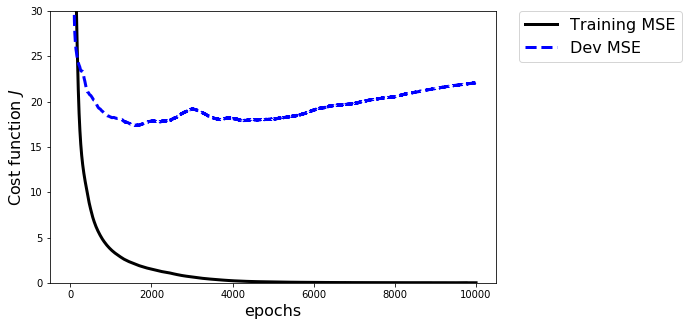

In [77]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(cost_train_history, ls='-', color = 'black', lw = 3, label = r'Training MSE')
ax.plot(cost_test_history, ls='--', color = 'blue', lw = 3, label = r'Dev MSE')
ax.set_xlabel('epochs', fontsize = 16)
ax.set_ylabel('Cost function $J$', fontsize = 16)
ax.set_ylim(0,30)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 16)

# Exercise 1 - Determine what architecture is not overfitting - Difficulty: easy

Try to determine which architecture (number of layers and number of neurons) is not overfitting the data. Try (**at least**) the following combinations

| Number of layers | Number of neurons each layer |
| --- | --- |
| 1 | 3 |
| 1 | 5 |
| 2 | 3 |
| 2 | 5 |

when the network starts overfitting? Which network would give a good result?

# Normal function

In [80]:
def model(training_epochs, features, target, logging_step = 100, learning_r = 0.001):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    cost_history = []
    for epoch in range(training_epochs+1):
        
        sess.run(optimizer, feed_dict = {X: features, Y: target, learning_rate: learning_r})
        cost_ = sess.run(cost, feed_dict={ X:features, Y: target, learning_rate: learning_r})
        cost_history = np.append(cost_history, cost_)

        if (epoch % logging_step == 0):
                print("Reached epoch",epoch,"cost J =", cost_)
                
    return sess, cost_history

In [81]:
sess, cost_history = model(learning_r = 0.01, 
                                training_epochs = 10000, 
                                features = train_x, 
                                target = train_y,
                                logging_step = 1000)

Reached epoch 0 cost J = 401.70294
Reached epoch 1000 cost J = 0.619966
Reached epoch 2000 cost J = 0.20663504
Reached epoch 3000 cost J = 0.11761165
Reached epoch 4000 cost J = 0.12322552
Reached epoch 5000 cost J = 0.031889617
Reached epoch 6000 cost J = 0.021233601
Reached epoch 7000 cost J = 0.017770553
Reached epoch 8000 cost J = 0.0074825976
Reached epoch 9000 cost J = 0.068383045
Reached epoch 10000 cost J = 0.014890215


# Plots

## Train & Test

Now an easy way of checking how our regression is working is to plot the **predicted** values vs. the **true** values. If our regression would be perfect all the points would like on the diagonal, if not they are spread around it.

(array([ 0., 10., 20., 30., 40., 50., 60.]),
 <a list of 7 Text yticklabel objects>)

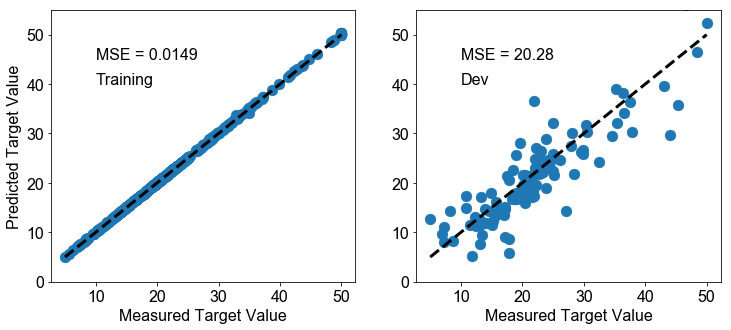

In [103]:
pred_y = sess.run(y_, feed_dict = {X: train_x, Y: train_y})
pred_y_test = sess.run(y_, feed_dict = {X: dev_x, Y: dev_y})
mse_train = sess.run(tf.reduce_mean(tf.square(pred_y - train_y)))
mse_test = sess.run(cost, feed_dict = {X: dev_x, Y: dev_y})

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(train_y, pred_y, lw = 0.3, s = 120)
ax.plot([np.min(np.array(dev_y)), np.max(np.array(dev_y))], [np.min(np.array(dev_y)), np.max(np.array(dev_y))], 'k--', lw = 3)
ax.set_xlabel('Measured Target Value', fontsize = 16)
ax.set_ylabel('Predicted Target Value', fontsize = 16)
ax.text(10,45, r'MSE = '+'{:5.4f}'.format(mse_train) , fontsize = 16)
ax.text(10,40, r'Training' , fontsize = 16)
ax.set_ylim(0,55)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 

ax = fig.add_subplot(1, 2, 2)
ax.scatter(dev_y, pred_y_test, lw = 0.3, s = 120)
ax.plot([np.min(np.array(dev_y)), np.max(np.array(dev_y))], [np.min(np.array(dev_y)), np.max(np.array(dev_y))], 'k--', lw = 3)
ax.set_xlabel('Measured Target Value', fontsize = 16)
ax.text(10,45, r'MSE = '+'{:5.2f}'.format(mse_test) , fontsize = 16)
ax.text(10,40, r'Dev' , fontsize = 16)
ax.set_ylim(0,55)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 

# L2 Regularization

Let's add L2 regularization to our network.

## Construction

In [104]:
tf.reset_default_graph()

n_dim = 13
n1 = 20
n2 = 20
n3 = 20
n4 = 20
n_outputs = 1

tf.set_random_seed(5)

X = tf.placeholder(tf.float32, [n_dim, None])
Y = tf.placeholder(tf.float32, [1, None])

learning_rate = tf.placeholder(tf.float32, shape=())
lambd = tf.placeholder(tf.float32, shape=())

hidden1, W1, b1 = create_layer (X, n1, activation = tf.nn.relu)
hidden2, W2, b2 = create_layer (hidden1, n2, activation = tf.nn.relu)
hidden3, W3, b3 = create_layer (hidden2, n3, activation = tf.nn.relu)
hidden4, W4, b4 = create_layer (hidden3, n4, activation = tf.nn.relu)
y_, W5, b5 = create_layer (hidden4, n_outputs, activation = tf.identity)

reg = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3) + \
          tf.nn.l2_loss(W4) + tf.nn.l2_loss(W5)

cost_mse = tf.reduce_mean(tf.square(y_-Y))

cost = tf.reduce_mean(cost_mse + lambd*reg)

# Adam
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8).minimize(cost)

In [105]:
def model(training_epochs, features, target, logging_step = 100, learning_r = 0.001, lambd_val = 0.1):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    cost_history = []
    for epoch in range(training_epochs+1):
        
        sess.run(optimizer, feed_dict = {X: features, Y: target, learning_rate: learning_r, lambd: lambd_val})
        cost_ = sess.run(cost_mse, feed_dict={ X:features, Y: target, learning_rate: learning_r, lambd: lambd_val})
        cost_history = np.append(cost_history, cost_)

        if (epoch % logging_step == 0):
                pred_y_test = sess.run(y_, feed_dict = {X: dev_x, Y: dev_y})
                print("Reached epoch",epoch,"cost J =", cost_)
                print("Training MSE = ", cost_)
                print("Dev MSE      = ", sess.run(cost_mse, feed_dict = {X: dev_x, Y: dev_y}))
                
    return sess, cost_history

In [106]:
sess, cost_history = model(learning_r = 0.01, 
                                training_epochs = 5000, 
                                features = train_x, 
                                target = train_y,
                                logging_step = 5000,
                                lambd_val = 10.0)

Reached epoch 0 cost J = 248.026
Training MSE =  248.026
Dev MSE      =  214.92079
Reached epoch 5000 cost J = 23.768053
Training MSE =  23.768053
Dev MSE      =  21.64329


In [107]:
sess, cost_history = model(learning_r = 0.01, 
                                training_epochs = 5000, 
                                features = train_x, 
                                target = train_y,
                                logging_step = 5000,
                                lambd_val = 0.0)

Reached epoch 0 cost J = 238.37778
Training MSE =  238.37778
Dev MSE      =  205.56093
Reached epoch 5000 cost J = 0.0047440524
Training MSE =  0.0047440524
Dev MSE      =  31.836403


# Exercise 2: find the minimum value for $\lambda$ for which the overfitting stops - Difficulty: medium

Perform a set of tests using the function

    sess, cost_history = model(learning_r = 0.01, 
                                training_epochs = 5000, 
                                features = train_x, 
                                target = train_y,
                                logging_step = 5000,
                                lambd_val = 0.0)
                             
varying the value of ```lambda_val``` from 0 to 10.0 in regular increment (you can decide what values you want to test). Use at minimum the values: 0, 0.5, 1.0, 2.0, 5.0, 7.0, 10.0, 15.0.
After that make a plot of the value for the cost function on the training dataset and on the dev dataset vs. $\lambda$.

## Number of weights that are zero

In [109]:
def eval_weights_stats(W):
    w_zero_count = np.sum(W < 1e-10)
    return w_zero_count 

In [110]:
sess, cost_history = model(learning_r = 0.01, 
                                training_epochs = 1000, 
                                features = train_x, 
                                target = train_y,
                                logging_step = 1000,
                                lambd_val = 0.0)

Reached epoch 0 cost J = 238.37778
Training MSE =  238.37778
Dev MSE      =  205.56093
Reached epoch 1000 cost J = 0.3379885
Training MSE =  0.3379885
Dev MSE      =  32.066654


In [111]:
weights1 = sess.run(W1,  feed_dict = {X: train_x, Y: train_y, learning_rate: 0.01, lambd: 0.0})
weights2 = sess.run(W2,  feed_dict = {X: train_x, Y: train_y, learning_rate: 0.01, lambd: 0.0})
weights3 = sess.run(W3,  feed_dict = {X: train_x, Y: train_y, learning_rate: 0.01, lambd: 0.0})
weights4 = sess.run(W4,  feed_dict = {X: train_x, Y: train_y, learning_rate: 0.01, lambd: 0.0})
weights5 = sess.run(W5,  feed_dict = {X: train_x, Y: train_y, learning_rate: 0.01, lambd: 0.0})

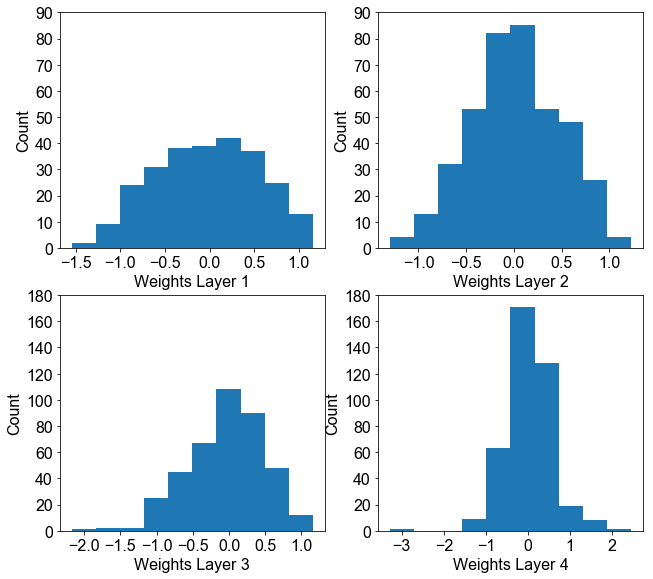

In [129]:
fig = plt.figure(figsize=(12, 8))

plt.tight_layout()

ax = fig.add_subplot(2, 2, 1)
plt.hist(weights1.flatten(), bins = 10)
ax.set_xlabel('Weights Layer 1', fontsize = 16)
ax.set_ylabel('Count', fontsize = 16)
plt.ylim(0,90)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 

ax = fig.add_subplot(2, 2, 2)
plt.hist(weights2.flatten(), bins = 10)
ax.set_xlabel('Weights Layer 2', fontsize = 16)
ax.set_ylabel('Count', fontsize = 16)
plt.ylim(0,90)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 


ax = fig.add_subplot(2, 2, 3)
plt.hist(weights3.flatten(), bins = 10)
ax.set_xlabel('Weights Layer 3', fontsize = 16)
ax.set_ylabel('Count', fontsize = 16)
plt.ylim(0,180)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 

ax = fig.add_subplot(2, 2, 4)
plt.hist(weights4.flatten(), bins = 10)
ax.set_xlabel('Weights Layer 4', fontsize = 16)
ax.set_ylabel('Count', fontsize = 16)
plt.ylim(0,180)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 

plt.subplots_adjust(bottom=0.0, right=0.8, top=0.9)
plt.show()

In [130]:
print((np.sum(np.abs(weights1)< 1e-3))/weights1.size*100.0)
print((np.sum(np.abs(weights2)< 1e-3))/weights2.size*100.0)
print((np.sum(np.abs(weights3)< 1e-3))/weights3.size*100.0)
print((np.sum(np.abs(weights4)< 1e-3))/weights4.size*100.0)
print((np.sum(np.abs(weights5)< 1e-3))/weights5.size*100.0)

0.0
0.25
0.5
0.25
0.0


In [131]:
sess, cost_history = model(learning_r = 0.01, 
                                training_epochs = 1000, 
                                features = train_x, 
                                target = train_y,
                                logging_step = 1000,
                                lambd_val = 10.0)

Reached epoch 0 cost J = 248.026
Training MSE =  248.026
Dev MSE      =  214.92079
Reached epoch 1000 cost J = 23.770224
Training MSE =  23.770224
Dev MSE      =  21.522156


In [132]:
weights1_ = sess.run(W1,  feed_dict = {X: train_x, Y: train_y, learning_rate: 0.01, lambd: 10.0})
weights2_ = sess.run(W2,  feed_dict = {X: train_x, Y: train_y, learning_rate: 0.01, lambd: 10.0})
weights3_ = sess.run(W3,  feed_dict = {X: train_x, Y: train_y, learning_rate: 0.01, lambd: 10.0})
weights4_ = sess.run(W4,  feed_dict = {X: train_x, Y: train_y, learning_rate: 0.01, lambd: 10.0})
weights5_ = sess.run(W5,  feed_dict = {X: train_x, Y: train_y, learning_rate: 0.01, lambd: 10.0})

In [133]:
print((np.sum(np.abs(weights1_)< 1e-3))/weights1_.size*100.0)
print((np.sum(np.abs(weights2_)< 1e-3))/weights2_.size*100.0)
print((np.sum(np.abs(weights3_)< 1e-3))/weights3_.size*100.0)
print((np.sum(np.abs(weights4_)< 1e-3))/weights4_.size*100.0)
print((np.sum(np.abs(weights5_)< 1e-3))/weights5_.size*100.0)

16.538461538461537
36.5
55.50000000000001
57.99999999999999
25.0


# Exercise 3: plot the amount of weights close to zero in layer 3 vs. $\lambda$ - Difficulty: medium

Considering only layer 3, plot the quantity

    (np.sum(np.abs(weights3_)< 1e-3))/weights3_.size*100.0
    
we have evaluated before and calculate it for several values of $\lambda$. Consider at least: 0, 0.5, 1.0, 2.0, 5.0, 7.0, 10.0, 15.0. Plot then the value vs. $\lambda$. What shape do the curve have? Does it flatten out?

## Histogram comparison

We can compare the histogram of the weights with and without regularization. The difference is quite stunning.

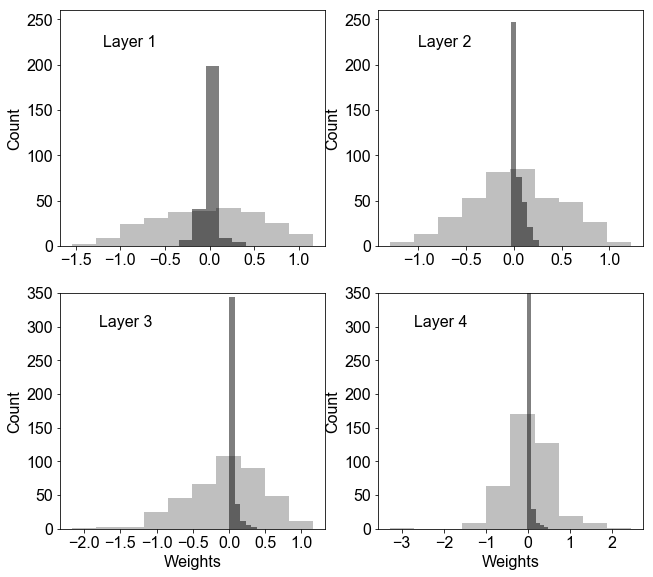

In [142]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(2, 2, 1)
plt.hist(weights1.flatten(), alpha = 0.25, bins = 10, color = 'black')
plt.hist(weights1_.flatten(), alpha = 0.5, bins = 5, color = 'black')
ax.set_ylabel('Count', fontsize = 16)
ax.text(-1.2, 220, r'Layer 1', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 
plt.ylim(0,260)

ax = fig.add_subplot(2, 2, 2)
plt.hist(weights2.flatten(), alpha = 0.25, bins = 10, color = 'black')
plt.hist(weights2_.flatten(), alpha = 0.5, bins = 5, color = 'black')
ax.set_ylabel('Count', fontsize = 16)
ax.text(-1, 220, r'Layer 2', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 
plt.ylim(0,260)


ax = fig.add_subplot(2, 2, 3)
plt.hist(weights3.flatten(), alpha = 0.25, bins = 10, color = 'black')
plt.hist(weights3_.flatten(), alpha = 0.5, bins = 5, color = 'black')
ax.set_xlabel('Weights', fontsize = 16)
ax.set_ylabel('Count', fontsize = 16)
ax.text(-1.8, 300, r'Layer 3', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 
plt.ylim(0,350)

ax = fig.add_subplot(2, 2, 4)
plt.hist(weights4.flatten(), alpha = 0.25, bins = 10, color = 'black')
plt.hist(weights4_.flatten(), alpha = 0.5, bins = 5, color = 'black')
ax.set_xlabel('Weights', fontsize = 16)
ax.set_ylabel('Count', fontsize = 16)
ax.text(-2.7, 300, r'Layer 4', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 
plt.ylim(0,350)

plt.subplots_adjust(bottom=0.0, right=0.8, top=0.9)
plt.show()

### Plot of visual comparison of dev and train with regularization

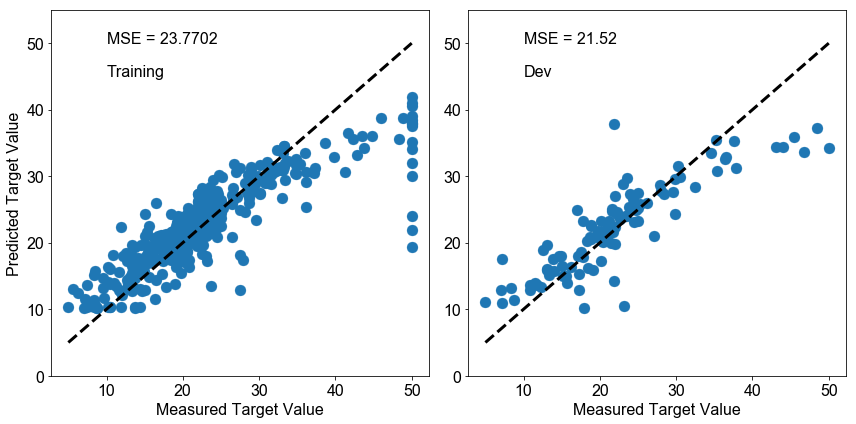

In [156]:
pred_y = sess.run(y_, feed_dict = {X: train_x, Y: train_y})
pred_y_dev = sess.run(y_, feed_dict = {X: dev_x, Y: dev_y})
mse_train = sess.run(tf.reduce_mean(tf.square(pred_y - train_y)))
mse_test = sess.run(cost_mse, feed_dict = {X: dev_x, Y: dev_y})



fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(train_y, pred_y, lw = 0.3, s = 120)
ax.plot([np.min(np.array(dev_y)), np.max(np.array(dev_y))], [np.min(np.array(dev_y)), np.max(np.array(dev_y))], 'k--', lw = 3)
ax.set_xlabel('Measured Target Value', fontsize = 16)
ax.set_ylabel('Predicted Target Value', fontsize = 16)
ax.text(10,50, r'MSE = '+'{:5.4f}'.format(mse_train) , fontsize = 16)
ax.text(10,45, r'Training' , fontsize = 16)
ax.set_ylim(0,55)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 

ax = fig.add_subplot(1, 2, 2)
ax.scatter(dev_y, pred_y_dev, lw = 0.3, s = 120)
ax.plot([np.min(np.array(dev_y)), np.max(np.array(dev_y))], [np.min(np.array(dev_y)), np.max(np.array(dev_y))], 'k--', lw = 3)
ax.set_xlabel('Measured Target Value', fontsize = 16)
#ax.set_ylabel('Predicted Target Value')
ax.text(10,50, r'MSE = '+'{:5.2f}'.format(mse_test) , fontsize = 16)
ax.text(10,45, r'Dev' , fontsize = 16)
ax.set_ylim(0,55)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 

plt.tight_layout()
plt.show()

# L1 Regularization

L1 regularization can be applied with tensorflow functions, but there is nto an easy way as with L2 (for some reasone). The method would be the following

    total_loss = meansq #or other loss calcuation
    l1_regularizer = tf.contrib.layers.l1_regularizer(
       scale=0.005, scope=None
    )
    weights = tf.trainable_variables() # all vars of your graph
    regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)

    regularized_loss = total_loss + regularization_penalty # this loss needs to be minimized
    train_step = tf.train.GradientDescentOptimizer(0.05).minimize(regularized_loss)
    
we will add it here manually.

In [157]:
tf.reset_default_graph()

n_dim = 13
n1 = 20
n2 = 20
n3 = 20
n4 = 20
n_outputs = 1


tf.set_random_seed(5)

X = tf.placeholder(tf.float32, [n_dim, None])
Y = tf.placeholder(tf.float32, [1, None])

learning_rate = tf.placeholder(tf.float32, shape=())
lambd = tf.placeholder(tf.float32, shape=())

hidden1, W1, b1 = create_layer (X, n1, activation = tf.nn.relu)
hidden2, W2, b2 = create_layer (hidden1, n2, activation = tf.nn.relu)
hidden3, W3, b3 = create_layer (hidden2, n3, activation = tf.nn.relu)
hidden4, W4, b4 = create_layer (hidden3, n4, activation = tf.nn.relu)
y_, W5, b5 = create_layer (hidden4, n_outputs, activation = tf.identity)
    
reg = tf.reduce_sum(tf.abs(W1))+tf.reduce_sum(tf.abs(W2))+tf.reduce_sum(tf.abs(W3))+\
        tf.reduce_sum(tf.abs(W4))+tf.reduce_sum(tf.abs(W5))

cost_mse = tf.reduce_mean(tf.square(y_-Y))

cost = tf.reduce_mean(cost_mse + lambd*reg)

# Adam
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8).minimize(cost)

In [158]:
def model(training_epochs, features, target, logging_step = 100, learning_r = 0.001, lambd_val = 0.1):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    cost_history = []
    for epoch in range(training_epochs+1):
        
        sess.run(optimizer, feed_dict = {X: features, Y: target, learning_rate: learning_r, lambd: lambd_val})
        cost_ = sess.run(cost_mse, feed_dict={ X:features, Y: target, learning_rate: learning_r, lambd: lambd_val})
        cost_history = np.append(cost_history, cost_)

        if (epoch % logging_step == 0):
                pred_y_test = sess.run(y_, feed_dict = {X: dev_x, Y: dev_y})
                print("Reached epoch",epoch,"cost J =", cost_)
                print("Training MSE = ", cost_)
                print("Dev MSE      = ", sess.run(cost_mse, feed_dict = {X: dev_x, Y: dev_y}))
                
    return sess, cost_history

In [159]:
sess, cost_history = model(learning_r = 0.01, 
                                training_epochs = 1000, 
                                features = train_x, 
                                target = train_y,
                                logging_step = 1000,
                                lambd_val = 0.0)

Reached epoch 0 cost J = 238.37778
Training MSE =  238.37778
Dev MSE      =  205.56093
Reached epoch 1000 cost J = 0.3379885
Training MSE =  0.3379885
Dev MSE      =  32.066654


In [160]:
weights1 = sess.run(W1,  feed_dict = {X: train_x, Y: train_y, learning_rate: 0.01, lambd: 10.0})
weights2 = sess.run(W2,  feed_dict = {X: train_x, Y: train_y, learning_rate: 0.01, lambd: 10.0})
weights3 = sess.run(W3,  feed_dict = {X: train_x, Y: train_y, learning_rate: 0.01, lambd: 10.0})
weights4 = sess.run(W4,  feed_dict = {X: train_x, Y: train_y, learning_rate: 0.01, lambd: 10.0})
weights5 = sess.run(W5,  feed_dict = {X: train_x, Y: train_y, learning_rate: 0.01, lambd: 10.0})

In [161]:
print((np.sum(np.abs(weights1)< 1e-3))/weights1.size*100.0)
print((np.sum(np.abs(weights2)< 1e-3))/weights2.size*100.0)
print((np.sum(np.abs(weights3)< 1e-3))/weights3.size*100.0)
print((np.sum(np.abs(weights4)< 1e-3))/weights4.size*100.0)
print((np.sum(np.abs(weights5)< 1e-3))/weights5.size*100.0)

0.0
0.25
0.5
0.25
0.0


In [163]:
sess, cost_history = model(learning_r = 0.01, 
                                training_epochs = 1000, 
                                features = train_x, 
                                target = train_y,
                                logging_step = 1000,
                                lambd_val = 10.0)

Reached epoch 0 cost J = 267.93192
Training MSE =  267.93192
Dev MSE      =  234.45863
Reached epoch 1000 cost J = 24.132565
Training MSE =  24.132565
Dev MSE      =  22.230083


In [165]:
print(eval_weights_stats(weights1)/weights1.size*100.0)
print(eval_weights_stats(weights2)/weights2.size*100.0)
print(eval_weights_stats(weights3)/weights3.size*100.0)
print(eval_weights_stats(weights4)/weights4.size*100.0)
print(eval_weights_stats(weights5)/weights5.size*100.0)

51.92307692307693
48.5
46.5
47.75
20.0


# How many weights are "exactly" zero?

we can also evaluate how many weights are really zero.

In [166]:
np.min(np.abs(weights1_))

3.7361951e-25

In [167]:
print((np.sum(np.abs(weights1_)<1e-5))/weights1_.size*100.0)
print((np.sum(np.abs(weights2_)<1e-5))/weights2_.size*100.0)
print((np.sum(np.abs(weights3_)<1e-5))/weights3_.size*100.0)
print((np.sum(np.abs(weights4_)< 1e-5))/weights4_.size*100.0)
print((np.sum(np.abs(weights5_)< 1e-5))/weights5_.size*100.0)

15.0
36.25
47.5
47.75
25.0


In [168]:
print(np.sum(np.abs(weights1_) < 5e-3))
print(np.sum(np.abs(weights2_) < 5e-3))
print(np.sum(np.abs(weights3_) < 5e-3))
print(np.sum(np.abs(weights4_) < 5e-3))

69
163
247
269


# Dropout Regularization

In [169]:
tf.reset_default_graph()

n_dim = 13
n1 = 20
n2 = 20
n3 = 20
n4 = 20
n_outputs = 1


tf.set_random_seed(5)

X = tf.placeholder(tf.float32, [n_dim, None])
Y = tf.placeholder(tf.float32, [1, None])

learning_rate = tf.placeholder(tf.float32, shape=())
keep_prob = tf.placeholder(tf.float32, shape=())

hidden1, W1, b1 = create_layer (X, n1, activation = tf.nn.relu)
hidden1_drop = tf.nn.dropout(hidden1, keep_prob)
hidden2, W2, b2 = create_layer (hidden1_drop, n2, activation = tf.nn.relu)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)
hidden3, W3, b3 = create_layer (hidden2, n3, activation = tf.nn.relu)
hidden3_drop = tf.nn.dropout(hidden3, keep_prob)
hidden4, W4, b4 = create_layer (hidden3, n4, activation = tf.nn.relu)
hidden4_drop = tf.nn.dropout(hidden4, keep_prob)
y_, W5, b5 = create_layer (hidden4_drop, n_outputs, activation = tf.identity)
  
cost = tf.reduce_mean(tf.square(y_-Y))

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8).minimize(cost)

In [170]:
def model(training_epochs, features, target, logging_step = 100, learning_r = 0.001,  keep_prob_val = 0.5):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    cost_history = []
    msetrain = []
    msedev = []
    for epoch in range(training_epochs+1):
        
        sess.run(optimizer, feed_dict = {X: features, Y: target, learning_rate: learning_r, keep_prob: keep_prob_val})
        cost_ = sess.run(cost, feed_dict={ X:features, Y: target, learning_rate: learning_r, keep_prob: keep_prob_val})
        cost_history = np.append(cost_history, cost_)
        msetrain = np.append(msetrain, cost_)
        msedev = np.append(msedev, sess.run(cost, feed_dict = {X: dev_x, Y: dev_y, keep_prob: 1.0}))

        if (epoch % logging_step == 0):
                pred_y_test = sess.run(y_, feed_dict = {X: dev_x, Y: dev_y, keep_prob: keep_prob_val})
                print("Reached epoch",epoch,"cost J =", cost_)
                print("Training MSE = ", cost_)
                print("Dev MSE      = ", sess.run(cost, feed_dict = {X: dev_x, Y: dev_y, keep_prob: 1.0}))
                
    return sess, cost_history, msetrain, msedev

In [172]:
sess, cost_history, mset, msed = model(learning_r = 0.01, 
                                training_epochs = 3000, 
                                features = train_x, 
                                target = train_y,
                                logging_step = 1000,
                                keep_prob_val = 1.0)

Reached epoch 0 cost J = 522.3576
Training MSE =  522.3576
Dev MSE      =  496.34427
Reached epoch 1000 cost J = 1.06591
Training MSE =  1.06591
Dev MSE      =  14.494189
Reached epoch 2000 cost J = 0.26527777
Training MSE =  0.26527777
Dev MSE      =  12.980678
Reached epoch 3000 cost J = 0.13220191
Training MSE =  0.13220191
Dev MSE      =  14.960528


In [174]:
sess, cost_history05, mset, msed = model(learning_r = 0.01, 
                                training_epochs = 3000, 
                                features = train_x, 
                                target = train_y,
                                logging_step = 1000,
                                keep_prob_val = 0.5)

Reached epoch 0 cost J = 551.21686
Training MSE =  551.21686
Dev MSE      =  500.0571
Reached epoch 1000 cost J = 35.295147
Training MSE =  35.295147
Dev MSE      =  52.90818
Reached epoch 2000 cost J = 19.613594
Training MSE =  19.613594
Dev MSE      =  40.99091
Reached epoch 3000 cost J = 14.614566
Training MSE =  14.614566
Dev MSE      =  35.864937


# Exercise 5: plot the cost functio with dropout - Difficulty: easy

What do you notice about the cost function with drop out? What do you notice?

# Exercise 6: implement L2 regularization by scratch - Difficulty: hard

Implement L2 regularization as we have done with L1 regularization without using the read tensorflow available function.